# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=350  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


     


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), (1024,1)]
    #cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384, (768,2), (1024,1)]
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512,1024,1024]
    cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384,768,1024]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        #print("X",out.shape)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=80 and (epoch-80)%10==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.306858, Accuracy: 10.16
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.283247, Accuracy: 11.91
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.154324, Accuracy: 15.04
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.000409, Accuracy: 20.70
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.971143, Accuracy: 26.37
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.840255, Accuracy: 30.08
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.783133, Accuracy: 33.40
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.726166, Accuracy: 30.66
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.775820, Accuracy: 35.74
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.761638, Accuracy: 36.72
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.765838, Accuracy: 36.52
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.721100, Accuracy: 35.16
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.595968, Accuracy: 41.60
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.614137, Accuracy: 40.62
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.636984, Accuracy: 36.91
Trai

Train Epoch: 6 [12800/50000 (28%)]	Loss: 0.829284, Accuracy: 70.90
Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.863778, Accuracy: 72.66
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.818992, Accuracy: 70.70
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.757195, Accuracy: 73.44
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.768791, Accuracy: 74.41
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.794421, Accuracy: 71.48
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.840349, Accuracy: 68.95
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.786836, Accuracy: 72.46
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.767642, Accuracy: 73.83
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.839415, Accuracy: 71.68
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.789885, Accuracy: 73.05
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.684422, Accuracy: 75.59
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.841222, Accuracy: 69.92

Validation set: Average loss: 0.9957, Accuracy: 3288/5000 (65.00%)

the time of this epoch:[17.364619255065918 s]
Train Epoch: 7

Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.657393, Accuracy: 77.15
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.585499, Accuracy: 79.30
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.499058, Accuracy: 84.96
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.511198, Accuracy: 81.05
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.615052, Accuracy: 78.91
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.558713, Accuracy: 80.08
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.602054, Accuracy: 80.08
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.525697, Accuracy: 82.81

Validation set: Average loss: 0.7669, Accuracy: 3733/5000 (74.00%)

the time of this epoch:[17.28410792350769 s]
Train Epoch: 13 [0/50000 (0%)]	Loss: 0.561733, Accuracy: 80.08
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.524755, Accuracy: 82.81
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.596425, Accuracy: 79.69
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.506807, Accuracy: 82.62
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.468224, Accuracy: 84.77
Train Epoch

Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.460570, Accuracy: 83.59
Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.542551, Accuracy: 79.10
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.485252, Accuracy: 83.59
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.517498, Accuracy: 83.40

Validation set: Average loss: 0.8679, Accuracy: 3515/5000 (70.00%)

the time of this epoch:[17.272619009017944 s]
Train Epoch: 19 [0/50000 (0%)]	Loss: 0.412485, Accuracy: 85.16
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.469131, Accuracy: 82.81
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.476943, Accuracy: 84.96
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.365717, Accuracy: 86.52
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.440809, Accuracy: 84.96
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.442679, Accuracy: 84.96
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.388716, Accuracy: 85.55
Train Epoch: 19 [17920/50000 (40%)]	Loss: 0.430378, Accuracy: 85.35
Train Epoch: 19 [20480/50000 (45%)]	Loss: 0.420282, Accuracy: 85.35
Train Epoc


Validation set: Average loss: 0.6379, Accuracy: 3958/5000 (79.00%)

the time of this epoch:[17.277761459350586 s]
Train Epoch: 25 [0/50000 (0%)]	Loss: 0.448593, Accuracy: 84.96
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.390940, Accuracy: 88.87
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.421061, Accuracy: 83.98
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.366627, Accuracy: 86.91
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.352902, Accuracy: 87.50
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.420973, Accuracy: 83.59
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.384549, Accuracy: 87.70
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.395486, Accuracy: 86.91
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.400834, Accuracy: 85.94
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.416978, Accuracy: 84.38
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.487572, Accuracy: 84.77
Train Epoch: 25 [28160/50000 (62%)]	Loss: 0.411979, Accuracy: 84.77
Train Epoch: 25 [30720/50000 (68%)]	Loss: 0.405928, Accuracy: 84.57
Train Epoc

Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.400284, Accuracy: 86.91
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.392467, Accuracy: 87.50
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.390018, Accuracy: 86.52
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.377712, Accuracy: 86.91
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.381177, Accuracy: 85.55
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.353371, Accuracy: 87.50
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.362049, Accuracy: 87.89
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.438114, Accuracy: 86.13
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.378962, Accuracy: 87.11
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.446242, Accuracy: 86.33
Train Epoch: 31 [30720/50000 (68%)]	Loss: 0.445820, Accuracy: 85.94
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.368107, Accuracy: 86.91
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.327087, Accuracy: 87.89
Train Epoch: 31 [38400/50000 (85%)]	Loss: 0.326600, Accuracy: 89.06
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.373790

Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.266350, Accuracy: 91.41
Train Epoch: 37 [17920/50000 (40%)]	Loss: 0.352961, Accuracy: 87.89
Train Epoch: 37 [20480/50000 (45%)]	Loss: 0.370410, Accuracy: 87.30
Train Epoch: 37 [23040/50000 (51%)]	Loss: 0.393337, Accuracy: 86.33
Train Epoch: 37 [25600/50000 (57%)]	Loss: 0.372905, Accuracy: 86.72
Train Epoch: 37 [28160/50000 (62%)]	Loss: 0.279490, Accuracy: 89.65
Train Epoch: 37 [30720/50000 (68%)]	Loss: 0.411922, Accuracy: 85.35
Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.352960, Accuracy: 86.72
Train Epoch: 37 [35840/50000 (80%)]	Loss: 0.413124, Accuracy: 85.94
Train Epoch: 37 [38400/50000 (85%)]	Loss: 0.368586, Accuracy: 85.94
Train Epoch: 37 [40960/50000 (91%)]	Loss: 0.337219, Accuracy: 88.09
Train Epoch: 37 [43520/50000 (97%)]	Loss: 0.336381, Accuracy: 87.70

Validation set: Average loss: 0.6206, Accuracy: 3955/5000 (79.00%)

the time of this epoch:[36.44732093811035 s]
Train Epoch: 38 [0/50000 (0%)]	Loss: 0.311092, Accuracy: 89.84
Train E

Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.364838, Accuracy: 86.72
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.351640, Accuracy: 87.50
Train Epoch: 43 [30720/50000 (68%)]	Loss: 0.293463, Accuracy: 89.65
Train Epoch: 43 [33280/50000 (74%)]	Loss: 0.428425, Accuracy: 85.74
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.303212, Accuracy: 89.45
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.382157, Accuracy: 85.94
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.313039, Accuracy: 87.89
Train Epoch: 43 [43520/50000 (97%)]	Loss: 0.371746, Accuracy: 87.11

Validation set: Average loss: 0.6092, Accuracy: 4007/5000 (80.00%)

the time of this epoch:[17.222015619277954 s]
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.256031, Accuracy: 91.60
Train Epoch: 44 [2560/50000 (6%)]	Loss: 0.335411, Accuracy: 88.09
Train Epoch: 44 [5120/50000 (11%)]	Loss: 0.359557, Accuracy: 88.09
Train Epoch: 44 [7680/50000 (17%)]	Loss: 0.301848, Accuracy: 90.43
Train Epoch: 44 [10240/50000 (23%)]	Loss: 0.318758, Accuracy: 89.45
Train Epoc

Train Epoch: 49 [35840/50000 (80%)]	Loss: 0.365894, Accuracy: 88.09
Train Epoch: 49 [38400/50000 (85%)]	Loss: 0.346046, Accuracy: 88.67
Train Epoch: 49 [40960/50000 (91%)]	Loss: 0.293568, Accuracy: 90.04
Train Epoch: 49 [43520/50000 (97%)]	Loss: 0.393207, Accuracy: 85.55

Validation set: Average loss: 0.5165, Accuracy: 4141/5000 (82.00%)

the time of this epoch:[17.261648178100586 s]
Train Epoch: 50 [0/50000 (0%)]	Loss: 0.346836, Accuracy: 87.70
Train Epoch: 50 [2560/50000 (6%)]	Loss: 0.296103, Accuracy: 89.84
Train Epoch: 50 [5120/50000 (11%)]	Loss: 0.283692, Accuracy: 91.21
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.336676, Accuracy: 89.84
Train Epoch: 50 [10240/50000 (23%)]	Loss: 0.317590, Accuracy: 89.06
Train Epoch: 50 [12800/50000 (28%)]	Loss: 0.348315, Accuracy: 88.67
Train Epoch: 50 [15360/50000 (34%)]	Loss: 0.312496, Accuracy: 88.67
Train Epoch: 50 [17920/50000 (40%)]	Loss: 0.250201, Accuracy: 91.02
Train Epoch: 50 [20480/50000 (45%)]	Loss: 0.380806, Accuracy: 88.09
Train Epoc


Validation set: Average loss: 0.6481, Accuracy: 3960/5000 (79.00%)

the time of this epoch:[17.332213401794434 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.254863, Accuracy: 91.80
Train Epoch: 56 [2560/50000 (6%)]	Loss: 0.295350, Accuracy: 89.45
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.233570, Accuracy: 92.38
Train Epoch: 56 [7680/50000 (17%)]	Loss: 0.329127, Accuracy: 89.06
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.263410, Accuracy: 89.65
Train Epoch: 56 [12800/50000 (28%)]	Loss: 0.290322, Accuracy: 90.62
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.336142, Accuracy: 87.30
Train Epoch: 56 [17920/50000 (40%)]	Loss: 0.305536, Accuracy: 89.65
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.245565, Accuracy: 91.41
Train Epoch: 56 [23040/50000 (51%)]	Loss: 0.308349, Accuracy: 88.67
Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.416013, Accuracy: 85.35
Train Epoch: 56 [28160/50000 (62%)]	Loss: 0.397582, Accuracy: 87.30
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.381808, Accuracy: 85.55
Train Epoc

Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.242887, Accuracy: 90.82
Train Epoch: 62 [7680/50000 (17%)]	Loss: 0.248694, Accuracy: 91.99
Train Epoch: 62 [10240/50000 (23%)]	Loss: 0.306255, Accuracy: 88.09
Train Epoch: 62 [12800/50000 (28%)]	Loss: 0.311300, Accuracy: 90.04
Train Epoch: 62 [15360/50000 (34%)]	Loss: 0.281752, Accuracy: 89.45
Train Epoch: 62 [17920/50000 (40%)]	Loss: 0.291765, Accuracy: 90.23
Train Epoch: 62 [20480/50000 (45%)]	Loss: 0.283359, Accuracy: 90.82
Train Epoch: 62 [23040/50000 (51%)]	Loss: 0.292508, Accuracy: 88.87
Train Epoch: 62 [25600/50000 (57%)]	Loss: 0.288156, Accuracy: 89.84
Train Epoch: 62 [28160/50000 (62%)]	Loss: 0.316547, Accuracy: 89.06
Train Epoch: 62 [30720/50000 (68%)]	Loss: 0.368497, Accuracy: 87.30
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.277716, Accuracy: 89.84
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.317900, Accuracy: 89.45
Train Epoch: 62 [38400/50000 (85%)]	Loss: 0.352166, Accuracy: 88.28
Train Epoch: 62 [40960/50000 (91%)]	Loss: 0.355843

Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.344371, Accuracy: 88.28
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.341303, Accuracy: 89.06
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.342012, Accuracy: 89.84
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.273497, Accuracy: 91.60
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.330070, Accuracy: 88.87
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.278874, Accuracy: 90.23
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.310940, Accuracy: 89.84
Train Epoch: 68 [33280/50000 (74%)]	Loss: 0.311819, Accuracy: 89.84
Train Epoch: 68 [35840/50000 (80%)]	Loss: 0.270031, Accuracy: 91.21
Train Epoch: 68 [38400/50000 (85%)]	Loss: 0.368751, Accuracy: 87.50
Train Epoch: 68 [40960/50000 (91%)]	Loss: 0.333880, Accuracy: 89.06
Train Epoch: 68 [43520/50000 (97%)]	Loss: 0.324550, Accuracy: 88.28

Validation set: Average loss: 0.4839, Accuracy: 4195/5000 (83.00%)

the time of this epoch:[17.26253652572632 s]
Train Epoch: 69 [0/50000 (0%)]	Loss: 0.245475, Accuracy: 92.58
Train E

Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.320770, Accuracy: 88.28
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.239731, Accuracy: 92.19
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.289760, Accuracy: 90.62
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.291960, Accuracy: 90.04
Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.340585, Accuracy: 86.52
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.361823, Accuracy: 88.67
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.269910, Accuracy: 89.45
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.318758, Accuracy: 89.65

Validation set: Average loss: 0.4981, Accuracy: 4174/5000 (83.00%)

the time of this epoch:[17.208164930343628 s]
Train Epoch: 75 [0/50000 (0%)]	Loss: 0.240150, Accuracy: 91.60
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.260935, Accuracy: 90.23
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.220531, Accuracy: 92.58
Train Epoch: 75 [7680/50000 (17%)]	Loss: 0.258368, Accuracy: 90.62
Train Epoch: 75 [10240/50000 (23%)]	Loss: 0.283833, Accuracy: 88.48
Train Epoc

Train Epoch: 80 [35840/50000 (80%)]	Loss: 0.257650, Accuracy: 91.02
Train Epoch: 80 [38400/50000 (85%)]	Loss: 0.278081, Accuracy: 90.82
Train Epoch: 80 [40960/50000 (91%)]	Loss: 0.312958, Accuracy: 90.23
Train Epoch: 80 [43520/50000 (97%)]	Loss: 0.294266, Accuracy: 90.04

Validation set: Average loss: 0.5159, Accuracy: 4172/5000 (83.00%)

the time of this epoch:[17.26512384414673 s]

Test set: Average loss: 0.5761, Accuracy: 8224/10000 (82.24%)

Train Epoch: 81 [0/50000 (0%)]	Loss: 0.274755, Accuracy: 89.84
Train Epoch: 81 [2560/50000 (6%)]	Loss: 0.278487, Accuracy: 90.82
Train Epoch: 81 [5120/50000 (11%)]	Loss: 0.281054, Accuracy: 90.82
Train Epoch: 81 [7680/50000 (17%)]	Loss: 0.298128, Accuracy: 89.84
Train Epoch: 81 [10240/50000 (23%)]	Loss: 0.241028, Accuracy: 91.41
Train Epoch: 81 [12800/50000 (28%)]	Loss: 0.337978, Accuracy: 88.87
Train Epoch: 81 [15360/50000 (34%)]	Loss: 0.289595, Accuracy: 91.02
Train Epoch: 81 [17920/50000 (40%)]	Loss: 0.273651, Accuracy: 91.21
Train Epoch: 81

Train Epoch: 86 [43520/50000 (97%)]	Loss: 0.322262, Accuracy: 88.67

Validation set: Average loss: 0.5072, Accuracy: 4167/5000 (83.00%)

the time of this epoch:[17.1864652633667 s]
Train Epoch: 87 [0/50000 (0%)]	Loss: 0.193250, Accuracy: 94.73
Train Epoch: 87 [2560/50000 (6%)]	Loss: 0.234001, Accuracy: 90.82
Train Epoch: 87 [5120/50000 (11%)]	Loss: 0.227335, Accuracy: 92.19
Train Epoch: 87 [7680/50000 (17%)]	Loss: 0.274392, Accuracy: 89.26
Train Epoch: 87 [10240/50000 (23%)]	Loss: 0.292277, Accuracy: 90.43
Train Epoch: 87 [12800/50000 (28%)]	Loss: 0.260098, Accuracy: 89.84
Train Epoch: 87 [15360/50000 (34%)]	Loss: 0.256368, Accuracy: 90.23
Train Epoch: 87 [17920/50000 (40%)]	Loss: 0.327116, Accuracy: 89.06
Train Epoch: 87 [20480/50000 (45%)]	Loss: 0.303856, Accuracy: 89.45
Train Epoch: 87 [23040/50000 (51%)]	Loss: 0.317635, Accuracy: 88.28
Train Epoch: 87 [25600/50000 (57%)]	Loss: 0.320802, Accuracy: 88.87
Train Epoch: 87 [28160/50000 (62%)]	Loss: 0.330524, Accuracy: 88.67
Train Epoch:

Train Epoch: 93 [2560/50000 (6%)]	Loss: 0.272358, Accuracy: 90.62
Train Epoch: 93 [5120/50000 (11%)]	Loss: 0.216066, Accuracy: 92.58
Train Epoch: 93 [7680/50000 (17%)]	Loss: 0.295147, Accuracy: 91.21
Train Epoch: 93 [10240/50000 (23%)]	Loss: 0.239691, Accuracy: 91.80
Train Epoch: 93 [12800/50000 (28%)]	Loss: 0.263383, Accuracy: 90.82
Train Epoch: 93 [15360/50000 (34%)]	Loss: 0.267199, Accuracy: 90.23
Train Epoch: 93 [17920/50000 (40%)]	Loss: 0.305020, Accuracy: 88.67
Train Epoch: 93 [20480/50000 (45%)]	Loss: 0.315111, Accuracy: 88.09
Train Epoch: 93 [23040/50000 (51%)]	Loss: 0.284184, Accuracy: 91.02
Train Epoch: 93 [25600/50000 (57%)]	Loss: 0.343070, Accuracy: 87.50
Train Epoch: 93 [28160/50000 (62%)]	Loss: 0.297605, Accuracy: 89.84
Train Epoch: 93 [30720/50000 (68%)]	Loss: 0.340547, Accuracy: 90.04
Train Epoch: 93 [33280/50000 (74%)]	Loss: 0.307042, Accuracy: 89.65
Train Epoch: 93 [35840/50000 (80%)]	Loss: 0.259970, Accuracy: 92.19
Train Epoch: 93 [38400/50000 (85%)]	Loss: 0.279048, 

Train Epoch: 99 [12800/50000 (28%)]	Loss: 0.265219, Accuracy: 90.62
Train Epoch: 99 [15360/50000 (34%)]	Loss: 0.255899, Accuracy: 91.41
Train Epoch: 99 [17920/50000 (40%)]	Loss: 0.277274, Accuracy: 89.45
Train Epoch: 99 [20480/50000 (45%)]	Loss: 0.335855, Accuracy: 87.50
Train Epoch: 99 [23040/50000 (51%)]	Loss: 0.229845, Accuracy: 92.38
Train Epoch: 99 [25600/50000 (57%)]	Loss: 0.230919, Accuracy: 91.02
Train Epoch: 99 [28160/50000 (62%)]	Loss: 0.322377, Accuracy: 88.48
Train Epoch: 99 [30720/50000 (68%)]	Loss: 0.315869, Accuracy: 89.84
Train Epoch: 99 [33280/50000 (74%)]	Loss: 0.293916, Accuracy: 89.45
Train Epoch: 99 [35840/50000 (80%)]	Loss: 0.274409, Accuracy: 89.65
Train Epoch: 99 [38400/50000 (85%)]	Loss: 0.240931, Accuracy: 92.19
Train Epoch: 99 [40960/50000 (91%)]	Loss: 0.302018, Accuracy: 90.04
Train Epoch: 99 [43520/50000 (97%)]	Loss: 0.280049, Accuracy: 89.65

Validation set: Average loss: 0.7831, Accuracy: 3795/5000 (75.00%)

the time of this epoch:[17.177481651306152 s]
T

Train Epoch: 105 [15360/50000 (34%)]	Loss: 0.111117, Accuracy: 96.88
Train Epoch: 105 [17920/50000 (40%)]	Loss: 0.112813, Accuracy: 96.68
Train Epoch: 105 [20480/50000 (45%)]	Loss: 0.107790, Accuracy: 96.29
Train Epoch: 105 [23040/50000 (51%)]	Loss: 0.065579, Accuracy: 97.27
Train Epoch: 105 [25600/50000 (57%)]	Loss: 0.130903, Accuracy: 95.70
Train Epoch: 105 [28160/50000 (62%)]	Loss: 0.106810, Accuracy: 96.48
Train Epoch: 105 [30720/50000 (68%)]	Loss: 0.100414, Accuracy: 96.29
Train Epoch: 105 [33280/50000 (74%)]	Loss: 0.113968, Accuracy: 96.09
Train Epoch: 105 [35840/50000 (80%)]	Loss: 0.140428, Accuracy: 94.73
Train Epoch: 105 [38400/50000 (85%)]	Loss: 0.105935, Accuracy: 96.48
Train Epoch: 105 [40960/50000 (91%)]	Loss: 0.091028, Accuracy: 96.88
Train Epoch: 105 [43520/50000 (97%)]	Loss: 0.113594, Accuracy: 95.31

Validation set: Average loss: 0.2950, Accuracy: 4558/5000 (91.00%)

the time of this epoch:[17.22921347618103 s]
Train Epoch: 106 [0/50000 (0%)]	Loss: 0.083714, Accuracy: 

Train Epoch: 111 [17920/50000 (40%)]	Loss: 0.117123, Accuracy: 96.88
Train Epoch: 111 [20480/50000 (45%)]	Loss: 0.068638, Accuracy: 97.27
Train Epoch: 111 [23040/50000 (51%)]	Loss: 0.063272, Accuracy: 97.07
Train Epoch: 111 [25600/50000 (57%)]	Loss: 0.053984, Accuracy: 99.02
Train Epoch: 111 [28160/50000 (62%)]	Loss: 0.100133, Accuracy: 96.68
Train Epoch: 111 [30720/50000 (68%)]	Loss: 0.056644, Accuracy: 98.05
Train Epoch: 111 [33280/50000 (74%)]	Loss: 0.128128, Accuracy: 94.73
Train Epoch: 111 [35840/50000 (80%)]	Loss: 0.083855, Accuracy: 96.88
Train Epoch: 111 [38400/50000 (85%)]	Loss: 0.080970, Accuracy: 97.27
Train Epoch: 111 [40960/50000 (91%)]	Loss: 0.062007, Accuracy: 98.44
Train Epoch: 111 [43520/50000 (97%)]	Loss: 0.094956, Accuracy: 97.27

Validation set: Average loss: 0.3143, Accuracy: 4565/5000 (91.00%)

the time of this epoch:[19.282093048095703 s]
Train Epoch: 112 [0/50000 (0%)]	Loss: 0.047161, Accuracy: 98.83
Train Epoch: 112 [2560/50000 (6%)]	Loss: 0.066241, Accuracy: 9

Train Epoch: 117 [23040/50000 (51%)]	Loss: 0.079918, Accuracy: 97.07
Train Epoch: 117 [25600/50000 (57%)]	Loss: 0.037831, Accuracy: 98.83
Train Epoch: 117 [28160/50000 (62%)]	Loss: 0.064116, Accuracy: 98.24
Train Epoch: 117 [30720/50000 (68%)]	Loss: 0.061958, Accuracy: 98.05
Train Epoch: 117 [33280/50000 (74%)]	Loss: 0.068275, Accuracy: 97.66
Train Epoch: 117 [35840/50000 (80%)]	Loss: 0.036886, Accuracy: 98.83
Train Epoch: 117 [38400/50000 (85%)]	Loss: 0.035559, Accuracy: 99.22
Train Epoch: 117 [40960/50000 (91%)]	Loss: 0.068376, Accuracy: 97.27
Train Epoch: 117 [43520/50000 (97%)]	Loss: 0.063161, Accuracy: 97.46

Validation set: Average loss: 0.3268, Accuracy: 4563/5000 (91.00%)

the time of this epoch:[17.20741891860962 s]
Train Epoch: 118 [0/50000 (0%)]	Loss: 0.033709, Accuracy: 98.83
Train Epoch: 118 [2560/50000 (6%)]	Loss: 0.076162, Accuracy: 97.66
Train Epoch: 118 [5120/50000 (11%)]	Loss: 0.065159, Accuracy: 97.46
Train Epoch: 118 [7680/50000 (17%)]	Loss: 0.051072, Accuracy: 98.2

Train Epoch: 123 [25600/50000 (57%)]	Loss: 0.063805, Accuracy: 97.46
Train Epoch: 123 [28160/50000 (62%)]	Loss: 0.049407, Accuracy: 98.24
Train Epoch: 123 [30720/50000 (68%)]	Loss: 0.039286, Accuracy: 98.44
Train Epoch: 123 [33280/50000 (74%)]	Loss: 0.041581, Accuracy: 98.24
Train Epoch: 123 [35840/50000 (80%)]	Loss: 0.049339, Accuracy: 97.85
Train Epoch: 123 [38400/50000 (85%)]	Loss: 0.048196, Accuracy: 98.24
Train Epoch: 123 [40960/50000 (91%)]	Loss: 0.029236, Accuracy: 99.02
Train Epoch: 123 [43520/50000 (97%)]	Loss: 0.079274, Accuracy: 97.46

Validation set: Average loss: 0.3323, Accuracy: 4553/5000 (91.00%)

the time of this epoch:[17.204962015151978 s]
Train Epoch: 124 [0/50000 (0%)]	Loss: 0.081035, Accuracy: 97.27
Train Epoch: 124 [2560/50000 (6%)]	Loss: 0.049771, Accuracy: 98.44
Train Epoch: 124 [5120/50000 (11%)]	Loss: 0.067124, Accuracy: 97.66
Train Epoch: 124 [7680/50000 (17%)]	Loss: 0.045557, Accuracy: 98.83
Train Epoch: 124 [10240/50000 (23%)]	Loss: 0.046890, Accuracy: 98.

Train Epoch: 129 [30720/50000 (68%)]	Loss: 0.027052, Accuracy: 99.02
Train Epoch: 129 [33280/50000 (74%)]	Loss: 0.040772, Accuracy: 99.02
Train Epoch: 129 [35840/50000 (80%)]	Loss: 0.058166, Accuracy: 98.24
Train Epoch: 129 [38400/50000 (85%)]	Loss: 0.026331, Accuracy: 99.02
Train Epoch: 129 [40960/50000 (91%)]	Loss: 0.053908, Accuracy: 98.24
Train Epoch: 129 [43520/50000 (97%)]	Loss: 0.046640, Accuracy: 98.44

Validation set: Average loss: 0.3559, Accuracy: 4538/5000 (90.00%)

the time of this epoch:[17.193726301193237 s]
Train Epoch: 130 [0/50000 (0%)]	Loss: 0.025838, Accuracy: 99.22
Train Epoch: 130 [2560/50000 (6%)]	Loss: 0.029919, Accuracy: 98.83
Train Epoch: 130 [5120/50000 (11%)]	Loss: 0.048968, Accuracy: 98.24
Train Epoch: 130 [7680/50000 (17%)]	Loss: 0.032779, Accuracy: 98.83
Train Epoch: 130 [10240/50000 (23%)]	Loss: 0.050970, Accuracy: 98.44
Train Epoch: 130 [12800/50000 (28%)]	Loss: 0.042627, Accuracy: 98.24
Train Epoch: 130 [15360/50000 (34%)]	Loss: 0.054389, Accuracy: 98.

Train Epoch: 135 [33280/50000 (74%)]	Loss: 0.027406, Accuracy: 99.22
Train Epoch: 135 [35840/50000 (80%)]	Loss: 0.043370, Accuracy: 98.44
Train Epoch: 135 [38400/50000 (85%)]	Loss: 0.051711, Accuracy: 98.24
Train Epoch: 135 [40960/50000 (91%)]	Loss: 0.050271, Accuracy: 98.83
Train Epoch: 135 [43520/50000 (97%)]	Loss: 0.046270, Accuracy: 97.85

Validation set: Average loss: 0.3783, Accuracy: 4530/5000 (90.00%)

the time of this epoch:[17.191632509231567 s]
Train Epoch: 136 [0/50000 (0%)]	Loss: 0.070864, Accuracy: 97.66
Train Epoch: 136 [2560/50000 (6%)]	Loss: 0.029868, Accuracy: 99.02
Train Epoch: 136 [5120/50000 (11%)]	Loss: 0.022270, Accuracy: 99.22
Train Epoch: 136 [7680/50000 (17%)]	Loss: 0.035297, Accuracy: 98.83
Train Epoch: 136 [10240/50000 (23%)]	Loss: 0.034651, Accuracy: 99.02
Train Epoch: 136 [12800/50000 (28%)]	Loss: 0.047830, Accuracy: 98.63
Train Epoch: 136 [15360/50000 (34%)]	Loss: 0.029558, Accuracy: 99.22
Train Epoch: 136 [17920/50000 (40%)]	Loss: 0.036653, Accuracy: 98.

Train Epoch: 141 [35840/50000 (80%)]	Loss: 0.035544, Accuracy: 99.22
Train Epoch: 141 [38400/50000 (85%)]	Loss: 0.044467, Accuracy: 98.63
Train Epoch: 141 [40960/50000 (91%)]	Loss: 0.036999, Accuracy: 98.83
Train Epoch: 141 [43520/50000 (97%)]	Loss: 0.015630, Accuracy: 99.41

Validation set: Average loss: 0.3807, Accuracy: 4535/5000 (90.00%)

the time of this epoch:[19.321786403656006 s]
Train Epoch: 142 [0/50000 (0%)]	Loss: 0.030368, Accuracy: 98.63
Train Epoch: 142 [2560/50000 (6%)]	Loss: 0.039886, Accuracy: 98.83
Train Epoch: 142 [5120/50000 (11%)]	Loss: 0.041128, Accuracy: 98.83
Train Epoch: 142 [7680/50000 (17%)]	Loss: 0.030193, Accuracy: 99.02
Train Epoch: 142 [10240/50000 (23%)]	Loss: 0.046639, Accuracy: 98.24
Train Epoch: 142 [12800/50000 (28%)]	Loss: 0.024459, Accuracy: 99.22
Train Epoch: 142 [15360/50000 (34%)]	Loss: 0.035811, Accuracy: 98.63
Train Epoch: 142 [17920/50000 (40%)]	Loss: 0.046916, Accuracy: 98.44
Train Epoch: 142 [20480/50000 (45%)]	Loss: 0.046860, Accuracy: 98.

Train Epoch: 147 [40960/50000 (91%)]	Loss: 0.028283, Accuracy: 99.02
Train Epoch: 147 [43520/50000 (97%)]	Loss: 0.033476, Accuracy: 99.41

Validation set: Average loss: 0.4067, Accuracy: 4515/5000 (90.00%)

the time of this epoch:[17.1802875995636 s]
Train Epoch: 148 [0/50000 (0%)]	Loss: 0.027845, Accuracy: 99.22
Train Epoch: 148 [2560/50000 (6%)]	Loss: 0.023608, Accuracy: 99.22
Train Epoch: 148 [5120/50000 (11%)]	Loss: 0.054814, Accuracy: 98.05
Train Epoch: 148 [7680/50000 (17%)]	Loss: 0.039254, Accuracy: 98.63
Train Epoch: 148 [10240/50000 (23%)]	Loss: 0.020482, Accuracy: 99.22
Train Epoch: 148 [12800/50000 (28%)]	Loss: 0.025401, Accuracy: 99.22
Train Epoch: 148 [15360/50000 (34%)]	Loss: 0.021560, Accuracy: 99.41
Train Epoch: 148 [17920/50000 (40%)]	Loss: 0.048412, Accuracy: 98.24
Train Epoch: 148 [20480/50000 (45%)]	Loss: 0.016644, Accuracy: 99.61
Train Epoch: 148 [23040/50000 (51%)]	Loss: 0.033729, Accuracy: 98.83
Train Epoch: 148 [25600/50000 (57%)]	Loss: 0.030660, Accuracy: 99.02

Train Epoch: 153 [43520/50000 (97%)]	Loss: 0.050508, Accuracy: 98.44

Validation set: Average loss: 0.3767, Accuracy: 4562/5000 (91.00%)

the time of this epoch:[17.225911378860474 s]
Train Epoch: 154 [0/50000 (0%)]	Loss: 0.028306, Accuracy: 99.61
Train Epoch: 154 [2560/50000 (6%)]	Loss: 0.029108, Accuracy: 99.02
Train Epoch: 154 [5120/50000 (11%)]	Loss: 0.037746, Accuracy: 98.83
Train Epoch: 154 [7680/50000 (17%)]	Loss: 0.031224, Accuracy: 99.02
Train Epoch: 154 [10240/50000 (23%)]	Loss: 0.029881, Accuracy: 99.02
Train Epoch: 154 [12800/50000 (28%)]	Loss: 0.028793, Accuracy: 99.02
Train Epoch: 154 [15360/50000 (34%)]	Loss: 0.014047, Accuracy: 99.80
Train Epoch: 154 [17920/50000 (40%)]	Loss: 0.040904, Accuracy: 99.02
Train Epoch: 154 [20480/50000 (45%)]	Loss: 0.030994, Accuracy: 98.83
Train Epoch: 154 [23040/50000 (51%)]	Loss: 0.045414, Accuracy: 98.05
Train Epoch: 154 [25600/50000 (57%)]	Loss: 0.029278, Accuracy: 99.02
Train Epoch: 154 [28160/50000 (62%)]	Loss: 0.041675, Accuracy: 99.

Train Epoch: 160 [2560/50000 (6%)]	Loss: 0.029085, Accuracy: 98.44
Train Epoch: 160 [5120/50000 (11%)]	Loss: 0.032804, Accuracy: 98.44
Train Epoch: 160 [7680/50000 (17%)]	Loss: 0.030190, Accuracy: 99.22
Train Epoch: 160 [10240/50000 (23%)]	Loss: 0.012004, Accuracy: 99.61
Train Epoch: 160 [12800/50000 (28%)]	Loss: 0.043355, Accuracy: 98.63
Train Epoch: 160 [15360/50000 (34%)]	Loss: 0.032560, Accuracy: 99.02
Train Epoch: 160 [17920/50000 (40%)]	Loss: 0.017768, Accuracy: 99.41
Train Epoch: 160 [20480/50000 (45%)]	Loss: 0.050000, Accuracy: 98.05
Train Epoch: 160 [23040/50000 (51%)]	Loss: 0.034022, Accuracy: 98.44
Train Epoch: 160 [25600/50000 (57%)]	Loss: 0.031019, Accuracy: 98.83
Train Epoch: 160 [28160/50000 (62%)]	Loss: 0.015663, Accuracy: 99.41
Train Epoch: 160 [30720/50000 (68%)]	Loss: 0.034916, Accuracy: 98.83
Train Epoch: 160 [33280/50000 (74%)]	Loss: 0.047253, Accuracy: 98.63
Train Epoch: 160 [35840/50000 (80%)]	Loss: 0.046484, Accuracy: 99.02
Train Epoch: 160 [38400/50000 (85%)]	L

Train Epoch: 166 [5120/50000 (11%)]	Loss: 0.020675, Accuracy: 99.61
Train Epoch: 166 [7680/50000 (17%)]	Loss: 0.024030, Accuracy: 99.02
Train Epoch: 166 [10240/50000 (23%)]	Loss: 0.036018, Accuracy: 99.02
Train Epoch: 166 [12800/50000 (28%)]	Loss: 0.022361, Accuracy: 99.61
Train Epoch: 166 [15360/50000 (34%)]	Loss: 0.015330, Accuracy: 99.41
Train Epoch: 166 [17920/50000 (40%)]	Loss: 0.041880, Accuracy: 98.05
Train Epoch: 166 [20480/50000 (45%)]	Loss: 0.015413, Accuracy: 99.41
Train Epoch: 166 [23040/50000 (51%)]	Loss: 0.030243, Accuracy: 98.83
Train Epoch: 166 [25600/50000 (57%)]	Loss: 0.013037, Accuracy: 99.61
Train Epoch: 166 [28160/50000 (62%)]	Loss: 0.065257, Accuracy: 97.66
Train Epoch: 166 [30720/50000 (68%)]	Loss: 0.055591, Accuracy: 98.05
Train Epoch: 166 [33280/50000 (74%)]	Loss: 0.024463, Accuracy: 99.41
Train Epoch: 166 [35840/50000 (80%)]	Loss: 0.026497, Accuracy: 99.41
Train Epoch: 166 [38400/50000 (85%)]	Loss: 0.027586, Accuracy: 99.22
Train Epoch: 166 [40960/50000 (91%)]

Train Epoch: 172 [7680/50000 (17%)]	Loss: 0.033458, Accuracy: 98.05
Train Epoch: 172 [10240/50000 (23%)]	Loss: 0.025686, Accuracy: 99.22
Train Epoch: 172 [12800/50000 (28%)]	Loss: 0.015950, Accuracy: 99.41
Train Epoch: 172 [15360/50000 (34%)]	Loss: 0.033861, Accuracy: 98.63
Train Epoch: 172 [17920/50000 (40%)]	Loss: 0.024648, Accuracy: 99.22
Train Epoch: 172 [20480/50000 (45%)]	Loss: 0.057057, Accuracy: 97.85
Train Epoch: 172 [23040/50000 (51%)]	Loss: 0.015109, Accuracy: 99.22
Train Epoch: 172 [25600/50000 (57%)]	Loss: 0.041713, Accuracy: 98.24
Train Epoch: 172 [28160/50000 (62%)]	Loss: 0.026594, Accuracy: 99.22
Train Epoch: 172 [30720/50000 (68%)]	Loss: 0.011893, Accuracy: 99.80
Train Epoch: 172 [33280/50000 (74%)]	Loss: 0.035257, Accuracy: 98.63
Train Epoch: 172 [35840/50000 (80%)]	Loss: 0.026194, Accuracy: 99.22
Train Epoch: 172 [38400/50000 (85%)]	Loss: 0.057539, Accuracy: 97.46
Train Epoch: 172 [40960/50000 (91%)]	Loss: 0.030430, Accuracy: 99.02
Train Epoch: 172 [43520/50000 (97%)

Train Epoch: 178 [12800/50000 (28%)]	Loss: 0.027456, Accuracy: 99.22
Train Epoch: 178 [15360/50000 (34%)]	Loss: 0.032783, Accuracy: 99.02
Train Epoch: 178 [17920/50000 (40%)]	Loss: 0.027299, Accuracy: 99.02
Train Epoch: 178 [20480/50000 (45%)]	Loss: 0.057991, Accuracy: 98.05
Train Epoch: 178 [23040/50000 (51%)]	Loss: 0.030799, Accuracy: 98.63
Train Epoch: 178 [25600/50000 (57%)]	Loss: 0.022682, Accuracy: 99.02
Train Epoch: 178 [28160/50000 (62%)]	Loss: 0.022500, Accuracy: 99.41
Train Epoch: 178 [30720/50000 (68%)]	Loss: 0.031066, Accuracy: 99.02
Train Epoch: 178 [33280/50000 (74%)]	Loss: 0.026396, Accuracy: 99.02
Train Epoch: 178 [35840/50000 (80%)]	Loss: 0.021594, Accuracy: 99.02
Train Epoch: 178 [38400/50000 (85%)]	Loss: 0.047040, Accuracy: 98.44
Train Epoch: 178 [40960/50000 (91%)]	Loss: 0.055510, Accuracy: 97.66
Train Epoch: 178 [43520/50000 (97%)]	Loss: 0.036807, Accuracy: 98.63

Validation set: Average loss: 0.4111, Accuracy: 4526/5000 (90.00%)

the time of this epoch:[17.2116401

Train Epoch: 184 [15360/50000 (34%)]	Loss: 0.022013, Accuracy: 99.41
Train Epoch: 184 [17920/50000 (40%)]	Loss: 0.017819, Accuracy: 99.41
Train Epoch: 184 [20480/50000 (45%)]	Loss: 0.041972, Accuracy: 98.83
Train Epoch: 184 [23040/50000 (51%)]	Loss: 0.046092, Accuracy: 98.63
Train Epoch: 184 [25600/50000 (57%)]	Loss: 0.032841, Accuracy: 99.41
Train Epoch: 184 [28160/50000 (62%)]	Loss: 0.032904, Accuracy: 99.02
Train Epoch: 184 [30720/50000 (68%)]	Loss: 0.028778, Accuracy: 98.83
Train Epoch: 184 [33280/50000 (74%)]	Loss: 0.025135, Accuracy: 99.02
Train Epoch: 184 [35840/50000 (80%)]	Loss: 0.038169, Accuracy: 98.44
Train Epoch: 184 [38400/50000 (85%)]	Loss: 0.021647, Accuracy: 99.61
Train Epoch: 184 [40960/50000 (91%)]	Loss: 0.043735, Accuracy: 98.24
Train Epoch: 184 [43520/50000 (97%)]	Loss: 0.039733, Accuracy: 98.63

Validation set: Average loss: 0.3964, Accuracy: 4529/5000 (90.00%)

the time of this epoch:[17.285597801208496 s]
Train Epoch: 185 [0/50000 (0%)]	Loss: 0.020596, Accuracy:

Train Epoch: 190 [20480/50000 (45%)]	Loss: 0.023406, Accuracy: 99.41
Train Epoch: 190 [23040/50000 (51%)]	Loss: 0.038420, Accuracy: 98.24
Train Epoch: 190 [25600/50000 (57%)]	Loss: 0.021926, Accuracy: 99.02
Train Epoch: 190 [28160/50000 (62%)]	Loss: 0.032541, Accuracy: 98.83
Train Epoch: 190 [30720/50000 (68%)]	Loss: 0.015981, Accuracy: 99.61
Train Epoch: 190 [33280/50000 (74%)]	Loss: 0.037614, Accuracy: 98.63
Train Epoch: 190 [35840/50000 (80%)]	Loss: 0.026066, Accuracy: 98.63
Train Epoch: 190 [38400/50000 (85%)]	Loss: 0.026239, Accuracy: 99.61
Train Epoch: 190 [40960/50000 (91%)]	Loss: 0.043359, Accuracy: 98.63
Train Epoch: 190 [43520/50000 (97%)]	Loss: 0.051998, Accuracy: 98.63

Validation set: Average loss: 0.4118, Accuracy: 4500/5000 (90.00%)

the time of this epoch:[17.213517427444458 s]

Test set: Average loss: 0.4466, Accuracy: 8971/10000 (89.71%)

Train Epoch: 191 [0/50000 (0%)]	Loss: 0.054215, Accuracy: 98.63
Train Epoch: 191 [2560/50000 (6%)]	Loss: 0.025681, Accuracy: 99.22


Train Epoch: 196 [23040/50000 (51%)]	Loss: 0.019665, Accuracy: 99.41
Train Epoch: 196 [25600/50000 (57%)]	Loss: 0.012776, Accuracy: 99.41
Train Epoch: 196 [28160/50000 (62%)]	Loss: 0.030649, Accuracy: 99.61
Train Epoch: 196 [30720/50000 (68%)]	Loss: 0.035709, Accuracy: 99.02
Train Epoch: 196 [33280/50000 (74%)]	Loss: 0.039138, Accuracy: 98.44
Train Epoch: 196 [35840/50000 (80%)]	Loss: 0.015153, Accuracy: 99.61
Train Epoch: 196 [38400/50000 (85%)]	Loss: 0.027681, Accuracy: 99.22
Train Epoch: 196 [40960/50000 (91%)]	Loss: 0.030642, Accuracy: 99.22
Train Epoch: 196 [43520/50000 (97%)]	Loss: 0.032701, Accuracy: 99.02

Validation set: Average loss: 0.3970, Accuracy: 4531/5000 (90.00%)

the time of this epoch:[17.18839383125305 s]
Train Epoch: 197 [0/50000 (0%)]	Loss: 0.018366, Accuracy: 99.41
Train Epoch: 197 [2560/50000 (6%)]	Loss: 0.036880, Accuracy: 98.83
Train Epoch: 197 [5120/50000 (11%)]	Loss: 0.025286, Accuracy: 99.22
Train Epoch: 197 [7680/50000 (17%)]	Loss: 0.050029, Accuracy: 98.2

Train Epoch: 202 [25600/50000 (57%)]	Loss: 0.031297, Accuracy: 99.41
Train Epoch: 202 [28160/50000 (62%)]	Loss: 0.021129, Accuracy: 99.22
Train Epoch: 202 [30720/50000 (68%)]	Loss: 0.009572, Accuracy: 99.80
Train Epoch: 202 [33280/50000 (74%)]	Loss: 0.015212, Accuracy: 99.61
Train Epoch: 202 [35840/50000 (80%)]	Loss: 0.006092, Accuracy: 100.00
Train Epoch: 202 [38400/50000 (85%)]	Loss: 0.020116, Accuracy: 99.41
Train Epoch: 202 [40960/50000 (91%)]	Loss: 0.014988, Accuracy: 99.41
Train Epoch: 202 [43520/50000 (97%)]	Loss: 0.011729, Accuracy: 99.80

Validation set: Average loss: 0.3587, Accuracy: 4582/5000 (91.00%)

the time of this epoch:[17.210357904434204 s]
Train Epoch: 203 [0/50000 (0%)]	Loss: 0.012759, Accuracy: 99.61
Train Epoch: 203 [2560/50000 (6%)]	Loss: 0.014483, Accuracy: 99.61
Train Epoch: 203 [5120/50000 (11%)]	Loss: 0.004941, Accuracy: 100.00
Train Epoch: 203 [7680/50000 (17%)]	Loss: 0.007710, Accuracy: 99.80
Train Epoch: 203 [10240/50000 (23%)]	Loss: 0.015046, Accuracy: 9

Train Epoch: 208 [30720/50000 (68%)]	Loss: 0.008461, Accuracy: 99.61
Train Epoch: 208 [33280/50000 (74%)]	Loss: 0.006466, Accuracy: 100.00
Train Epoch: 208 [35840/50000 (80%)]	Loss: 0.009651, Accuracy: 100.00
Train Epoch: 208 [38400/50000 (85%)]	Loss: 0.009745, Accuracy: 99.41
Train Epoch: 208 [40960/50000 (91%)]	Loss: 0.005375, Accuracy: 100.00
Train Epoch: 208 [43520/50000 (97%)]	Loss: 0.010936, Accuracy: 99.61

Validation set: Average loss: 0.3690, Accuracy: 4570/5000 (91.00%)

the time of this epoch:[17.24748396873474 s]
Train Epoch: 209 [0/50000 (0%)]	Loss: 0.010298, Accuracy: 99.61
Train Epoch: 209 [2560/50000 (6%)]	Loss: 0.004687, Accuracy: 100.00
Train Epoch: 209 [5120/50000 (11%)]	Loss: 0.006069, Accuracy: 100.00
Train Epoch: 209 [7680/50000 (17%)]	Loss: 0.005776, Accuracy: 99.80
Train Epoch: 209 [10240/50000 (23%)]	Loss: 0.011480, Accuracy: 99.80
Train Epoch: 209 [12800/50000 (28%)]	Loss: 0.004438, Accuracy: 100.00
Train Epoch: 209 [15360/50000 (34%)]	Loss: 0.014430, Accuracy

Train Epoch: 214 [33280/50000 (74%)]	Loss: 0.002807, Accuracy: 100.00
Train Epoch: 214 [35840/50000 (80%)]	Loss: 0.003014, Accuracy: 100.00
Train Epoch: 214 [38400/50000 (85%)]	Loss: 0.004966, Accuracy: 100.00
Train Epoch: 214 [40960/50000 (91%)]	Loss: 0.029045, Accuracy: 98.83
Train Epoch: 214 [43520/50000 (97%)]	Loss: 0.007776, Accuracy: 99.80

Validation set: Average loss: 0.3715, Accuracy: 4587/5000 (91.00%)

the time of this epoch:[17.309006929397583 s]
Train Epoch: 215 [0/50000 (0%)]	Loss: 0.003883, Accuracy: 100.00
Train Epoch: 215 [2560/50000 (6%)]	Loss: 0.007364, Accuracy: 99.80
Train Epoch: 215 [5120/50000 (11%)]	Loss: 0.005142, Accuracy: 100.00
Train Epoch: 215 [7680/50000 (17%)]	Loss: 0.010762, Accuracy: 99.80
Train Epoch: 215 [10240/50000 (23%)]	Loss: 0.013063, Accuracy: 99.80
Train Epoch: 215 [12800/50000 (28%)]	Loss: 0.005722, Accuracy: 99.80
Train Epoch: 215 [15360/50000 (34%)]	Loss: 0.005111, Accuracy: 100.00
Train Epoch: 215 [17920/50000 (40%)]	Loss: 0.004839, Accurac

Train Epoch: 220 [35840/50000 (80%)]	Loss: 0.003795, Accuracy: 100.00
Train Epoch: 220 [38400/50000 (85%)]	Loss: 0.018281, Accuracy: 99.41
Train Epoch: 220 [40960/50000 (91%)]	Loss: 0.008369, Accuracy: 99.80
Train Epoch: 220 [43520/50000 (97%)]	Loss: 0.003350, Accuracy: 100.00

Validation set: Average loss: 0.3798, Accuracy: 4583/5000 (91.00%)

the time of this epoch:[17.221521615982056 s]

Test set: Average loss: 0.4290, Accuracy: 9057/10000 (90.57%)

Train Epoch: 221 [0/50000 (0%)]	Loss: 0.003357, Accuracy: 100.00
Train Epoch: 221 [2560/50000 (6%)]	Loss: 0.012345, Accuracy: 99.61
Train Epoch: 221 [5120/50000 (11%)]	Loss: 0.005122, Accuracy: 100.00
Train Epoch: 221 [7680/50000 (17%)]	Loss: 0.003179, Accuracy: 100.00
Train Epoch: 221 [10240/50000 (23%)]	Loss: 0.003916, Accuracy: 100.00
Train Epoch: 221 [12800/50000 (28%)]	Loss: 0.011212, Accuracy: 99.61
Train Epoch: 221 [15360/50000 (34%)]	Loss: 0.007693, Accuracy: 99.61
Train Epoch: 221 [17920/50000 (40%)]	Loss: 0.015456, Accuracy: 99

Train Epoch: 226 [38400/50000 (85%)]	Loss: 0.003286, Accuracy: 100.00
Train Epoch: 226 [40960/50000 (91%)]	Loss: 0.015686, Accuracy: 99.80
Train Epoch: 226 [43520/50000 (97%)]	Loss: 0.006747, Accuracy: 99.80

Validation set: Average loss: 0.3842, Accuracy: 4580/5000 (91.00%)

the time of this epoch:[17.31977868080139 s]
Train Epoch: 227 [0/50000 (0%)]	Loss: 0.004685, Accuracy: 100.00
Train Epoch: 227 [2560/50000 (6%)]	Loss: 0.003146, Accuracy: 100.00
Train Epoch: 227 [5120/50000 (11%)]	Loss: 0.003726, Accuracy: 100.00
Train Epoch: 227 [7680/50000 (17%)]	Loss: 0.015452, Accuracy: 99.41
Train Epoch: 227 [10240/50000 (23%)]	Loss: 0.009677, Accuracy: 99.61
Train Epoch: 227 [12800/50000 (28%)]	Loss: 0.005940, Accuracy: 99.80
Train Epoch: 227 [15360/50000 (34%)]	Loss: 0.009567, Accuracy: 99.80
Train Epoch: 227 [17920/50000 (40%)]	Loss: 0.007523, Accuracy: 99.80
Train Epoch: 227 [20480/50000 (45%)]	Loss: 0.003903, Accuracy: 100.00
Train Epoch: 227 [23040/50000 (51%)]	Loss: 0.008721, Accuracy:

Train Epoch: 232 [38400/50000 (85%)]	Loss: 0.026962, Accuracy: 99.22
Train Epoch: 232 [40960/50000 (91%)]	Loss: 0.002857, Accuracy: 100.00
Train Epoch: 232 [43520/50000 (97%)]	Loss: 0.015904, Accuracy: 99.80

Validation set: Average loss: 0.3921, Accuracy: 4584/5000 (91.00%)

the time of this epoch:[17.189759731292725 s]
Train Epoch: 233 [0/50000 (0%)]	Loss: 0.005933, Accuracy: 99.80
Train Epoch: 233 [2560/50000 (6%)]	Loss: 0.009419, Accuracy: 99.61
Train Epoch: 233 [5120/50000 (11%)]	Loss: 0.006678, Accuracy: 99.80
Train Epoch: 233 [7680/50000 (17%)]	Loss: 0.003130, Accuracy: 100.00
Train Epoch: 233 [10240/50000 (23%)]	Loss: 0.007747, Accuracy: 99.80
Train Epoch: 233 [12800/50000 (28%)]	Loss: 0.006108, Accuracy: 99.80
Train Epoch: 233 [15360/50000 (34%)]	Loss: 0.003148, Accuracy: 100.00
Train Epoch: 233 [17920/50000 (40%)]	Loss: 0.015621, Accuracy: 99.61
Train Epoch: 233 [20480/50000 (45%)]	Loss: 0.004296, Accuracy: 99.80
Train Epoch: 233 [23040/50000 (51%)]	Loss: 0.002177, Accuracy: 

Train Epoch: 238 [40960/50000 (91%)]	Loss: 0.006008, Accuracy: 99.80
Train Epoch: 238 [43520/50000 (97%)]	Loss: 0.006071, Accuracy: 99.80

Validation set: Average loss: 0.3957, Accuracy: 4575/5000 (91.00%)

the time of this epoch:[17.232574224472046 s]
Train Epoch: 239 [0/50000 (0%)]	Loss: 0.010296, Accuracy: 99.61
Train Epoch: 239 [2560/50000 (6%)]	Loss: 0.012316, Accuracy: 99.80
Train Epoch: 239 [5120/50000 (11%)]	Loss: 0.015544, Accuracy: 99.61
Train Epoch: 239 [7680/50000 (17%)]	Loss: 0.004956, Accuracy: 99.80
Train Epoch: 239 [10240/50000 (23%)]	Loss: 0.011345, Accuracy: 99.61
Train Epoch: 239 [12800/50000 (28%)]	Loss: 0.005505, Accuracy: 100.00
Train Epoch: 239 [15360/50000 (34%)]	Loss: 0.006971, Accuracy: 99.80
Train Epoch: 239 [17920/50000 (40%)]	Loss: 0.003656, Accuracy: 100.00
Train Epoch: 239 [20480/50000 (45%)]	Loss: 0.007399, Accuracy: 99.80
Train Epoch: 239 [23040/50000 (51%)]	Loss: 0.009261, Accuracy: 99.80
Train Epoch: 239 [25600/50000 (57%)]	Loss: 0.005433, Accuracy: 1

Train Epoch: 244 [40960/50000 (91%)]	Loss: 0.002360, Accuracy: 100.00
Train Epoch: 244 [43520/50000 (97%)]	Loss: 0.003394, Accuracy: 100.00

Validation set: Average loss: 0.3940, Accuracy: 4578/5000 (91.00%)

the time of this epoch:[17.32182264328003 s]
Train Epoch: 245 [0/50000 (0%)]	Loss: 0.003397, Accuracy: 100.00
Train Epoch: 245 [2560/50000 (6%)]	Loss: 0.003833, Accuracy: 99.80
Train Epoch: 245 [5120/50000 (11%)]	Loss: 0.005483, Accuracy: 99.80
Train Epoch: 245 [7680/50000 (17%)]	Loss: 0.004263, Accuracy: 100.00
Train Epoch: 245 [10240/50000 (23%)]	Loss: 0.002063, Accuracy: 100.00
Train Epoch: 245 [12800/50000 (28%)]	Loss: 0.010517, Accuracy: 99.61
Train Epoch: 245 [15360/50000 (34%)]	Loss: 0.007490, Accuracy: 99.80
Train Epoch: 245 [17920/50000 (40%)]	Loss: 0.002159, Accuracy: 100.00
Train Epoch: 245 [20480/50000 (45%)]	Loss: 0.005430, Accuracy: 100.00
Train Epoch: 245 [23040/50000 (51%)]	Loss: 0.006187, Accuracy: 99.80
Train Epoch: 245 [25600/50000 (57%)]	Loss: 0.003304, Accurac

Train Epoch: 250 [43520/50000 (97%)]	Loss: 0.002445, Accuracy: 100.00

Validation set: Average loss: 0.4029, Accuracy: 4579/5000 (91.00%)

the time of this epoch:[17.261124849319458 s]

Test set: Average loss: 0.4530, Accuracy: 9063/10000 (90.63%)

Train Epoch: 251 [0/50000 (0%)]	Loss: 0.001898, Accuracy: 100.00
Train Epoch: 251 [2560/50000 (6%)]	Loss: 0.002035, Accuracy: 100.00
Train Epoch: 251 [5120/50000 (11%)]	Loss: 0.004978, Accuracy: 100.00
Train Epoch: 251 [7680/50000 (17%)]	Loss: 0.002956, Accuracy: 100.00
Train Epoch: 251 [10240/50000 (23%)]	Loss: 0.019126, Accuracy: 99.41
Train Epoch: 251 [12800/50000 (28%)]	Loss: 0.003674, Accuracy: 99.80
Train Epoch: 251 [15360/50000 (34%)]	Loss: 0.004046, Accuracy: 100.00
Train Epoch: 251 [17920/50000 (40%)]	Loss: 0.002341, Accuracy: 100.00
Train Epoch: 251 [20480/50000 (45%)]	Loss: 0.017985, Accuracy: 99.61
Train Epoch: 251 [23040/50000 (51%)]	Loss: 0.004535, Accuracy: 99.80
Train Epoch: 251 [25600/50000 (57%)]	Loss: 0.001781, Accuracy: 1

Train Epoch: 256 [43520/50000 (97%)]	Loss: 0.012804, Accuracy: 99.61

Validation set: Average loss: 0.4089, Accuracy: 4580/5000 (91.00%)

the time of this epoch:[17.293781042099 s]
Train Epoch: 257 [0/50000 (0%)]	Loss: 0.002035, Accuracy: 100.00
Train Epoch: 257 [2560/50000 (6%)]	Loss: 0.004089, Accuracy: 100.00
Train Epoch: 257 [5120/50000 (11%)]	Loss: 0.005100, Accuracy: 99.80
Train Epoch: 257 [7680/50000 (17%)]	Loss: 0.002113, Accuracy: 100.00
Train Epoch: 257 [10240/50000 (23%)]	Loss: 0.007634, Accuracy: 99.80
Train Epoch: 257 [12800/50000 (28%)]	Loss: 0.003649, Accuracy: 99.80
Train Epoch: 257 [15360/50000 (34%)]	Loss: 0.004271, Accuracy: 100.00
Train Epoch: 257 [17920/50000 (40%)]	Loss: 0.007213, Accuracy: 99.80
Train Epoch: 257 [20480/50000 (45%)]	Loss: 0.004196, Accuracy: 99.80
Train Epoch: 257 [23040/50000 (51%)]	Loss: 0.002771, Accuracy: 100.00
Train Epoch: 257 [25600/50000 (57%)]	Loss: 0.002807, Accuracy: 100.00
Train Epoch: 257 [28160/50000 (62%)]	Loss: 0.002442, Accuracy: 

Train Epoch: 262 [43520/50000 (97%)]	Loss: 0.003623, Accuracy: 99.80

Validation set: Average loss: 0.4055, Accuracy: 4576/5000 (91.00%)

the time of this epoch:[17.26417875289917 s]
Train Epoch: 263 [0/50000 (0%)]	Loss: 0.005296, Accuracy: 100.00
Train Epoch: 263 [2560/50000 (6%)]	Loss: 0.003294, Accuracy: 100.00
Train Epoch: 263 [5120/50000 (11%)]	Loss: 0.002349, Accuracy: 100.00
Train Epoch: 263 [7680/50000 (17%)]	Loss: 0.007048, Accuracy: 99.80
Train Epoch: 263 [10240/50000 (23%)]	Loss: 0.002816, Accuracy: 100.00
Train Epoch: 263 [12800/50000 (28%)]	Loss: 0.003742, Accuracy: 99.80
Train Epoch: 263 [15360/50000 (34%)]	Loss: 0.004091, Accuracy: 100.00
Train Epoch: 263 [17920/50000 (40%)]	Loss: 0.003001, Accuracy: 100.00
Train Epoch: 263 [20480/50000 (45%)]	Loss: 0.002856, Accuracy: 100.00
Train Epoch: 263 [23040/50000 (51%)]	Loss: 0.001621, Accuracy: 100.00
Train Epoch: 263 [25600/50000 (57%)]	Loss: 0.004221, Accuracy: 99.80
Train Epoch: 263 [28160/50000 (62%)]	Loss: 0.003231, Accura


Validation set: Average loss: 0.4102, Accuracy: 4577/5000 (91.00%)

the time of this epoch:[17.230950355529785 s]
Train Epoch: 269 [0/50000 (0%)]	Loss: 0.004114, Accuracy: 99.80
Train Epoch: 269 [2560/50000 (6%)]	Loss: 0.001876, Accuracy: 100.00
Train Epoch: 269 [5120/50000 (11%)]	Loss: 0.005421, Accuracy: 99.80
Train Epoch: 269 [7680/50000 (17%)]	Loss: 0.002990, Accuracy: 100.00
Train Epoch: 269 [10240/50000 (23%)]	Loss: 0.010618, Accuracy: 99.80
Train Epoch: 269 [12800/50000 (28%)]	Loss: 0.004320, Accuracy: 99.80
Train Epoch: 269 [15360/50000 (34%)]	Loss: 0.002447, Accuracy: 100.00
Train Epoch: 269 [17920/50000 (40%)]	Loss: 0.001555, Accuracy: 100.00
Train Epoch: 269 [20480/50000 (45%)]	Loss: 0.002517, Accuracy: 100.00
Train Epoch: 269 [23040/50000 (51%)]	Loss: 0.003243, Accuracy: 100.00
Train Epoch: 269 [25600/50000 (57%)]	Loss: 0.004662, Accuracy: 99.80
Train Epoch: 269 [28160/50000 (62%)]	Loss: 0.003953, Accuracy: 99.80
Train Epoch: 269 [30720/50000 (68%)]	Loss: 0.012959, Accurac


Validation set: Average loss: 0.4090, Accuracy: 4585/5000 (91.00%)

the time of this epoch:[17.25408935546875 s]
Train Epoch: 275 [0/50000 (0%)]	Loss: 0.001717, Accuracy: 100.00
Train Epoch: 275 [2560/50000 (6%)]	Loss: 0.006510, Accuracy: 99.80
Train Epoch: 275 [5120/50000 (11%)]	Loss: 0.001947, Accuracy: 100.00
Train Epoch: 275 [7680/50000 (17%)]	Loss: 0.001828, Accuracy: 100.00
Train Epoch: 275 [10240/50000 (23%)]	Loss: 0.002551, Accuracy: 100.00
Train Epoch: 275 [12800/50000 (28%)]	Loss: 0.002341, Accuracy: 100.00
Train Epoch: 275 [15360/50000 (34%)]	Loss: 0.002969, Accuracy: 100.00
Train Epoch: 275 [17920/50000 (40%)]	Loss: 0.003432, Accuracy: 100.00
Train Epoch: 275 [20480/50000 (45%)]	Loss: 0.001991, Accuracy: 100.00
Train Epoch: 275 [23040/50000 (51%)]	Loss: 0.003750, Accuracy: 99.80
Train Epoch: 275 [25600/50000 (57%)]	Loss: 0.005533, Accuracy: 99.80
Train Epoch: 275 [28160/50000 (62%)]	Loss: 0.003860, Accuracy: 99.80
Train Epoch: 275 [30720/50000 (68%)]	Loss: 0.003983, Accura


Test set: Average loss: 0.4664, Accuracy: 9054/10000 (90.54%)

Train Epoch: 281 [0/50000 (0%)]	Loss: 0.002406, Accuracy: 100.00
Train Epoch: 281 [2560/50000 (6%)]	Loss: 0.002173, Accuracy: 100.00
Train Epoch: 281 [5120/50000 (11%)]	Loss: 0.001776, Accuracy: 100.00
Train Epoch: 281 [7680/50000 (17%)]	Loss: 0.002002, Accuracy: 100.00
Train Epoch: 281 [10240/50000 (23%)]	Loss: 0.003033, Accuracy: 100.00
Train Epoch: 281 [12800/50000 (28%)]	Loss: 0.002667, Accuracy: 100.00
Train Epoch: 281 [15360/50000 (34%)]	Loss: 0.002005, Accuracy: 100.00
Train Epoch: 281 [17920/50000 (40%)]	Loss: 0.002178, Accuracy: 100.00
Train Epoch: 281 [20480/50000 (45%)]	Loss: 0.001841, Accuracy: 100.00
Train Epoch: 281 [23040/50000 (51%)]	Loss: 0.004305, Accuracy: 100.00
Train Epoch: 281 [25600/50000 (57%)]	Loss: 0.003271, Accuracy: 100.00
Train Epoch: 281 [28160/50000 (62%)]	Loss: 0.001493, Accuracy: 100.00
Train Epoch: 281 [30720/50000 (68%)]	Loss: 0.005730, Accuracy: 99.80
Train Epoch: 281 [33280/50000 (74%)]

Train Epoch: 287 [2560/50000 (6%)]	Loss: 0.003604, Accuracy: 100.00
Train Epoch: 287 [5120/50000 (11%)]	Loss: 0.002989, Accuracy: 100.00
Train Epoch: 287 [7680/50000 (17%)]	Loss: 0.001343, Accuracy: 100.00
Train Epoch: 287 [10240/50000 (23%)]	Loss: 0.001488, Accuracy: 100.00
Train Epoch: 287 [12800/50000 (28%)]	Loss: 0.003993, Accuracy: 100.00
Train Epoch: 287 [15360/50000 (34%)]	Loss: 0.002817, Accuracy: 100.00
Train Epoch: 287 [17920/50000 (40%)]	Loss: 0.004318, Accuracy: 99.80
Train Epoch: 287 [20480/50000 (45%)]	Loss: 0.007109, Accuracy: 99.80
Train Epoch: 287 [23040/50000 (51%)]	Loss: 0.009189, Accuracy: 99.61
Train Epoch: 287 [25600/50000 (57%)]	Loss: 0.007785, Accuracy: 99.61
Train Epoch: 287 [28160/50000 (62%)]	Loss: 0.002838, Accuracy: 100.00
Train Epoch: 287 [30720/50000 (68%)]	Loss: 0.014448, Accuracy: 99.80
Train Epoch: 287 [33280/50000 (74%)]	Loss: 0.002553, Accuracy: 100.00
Train Epoch: 287 [35840/50000 (80%)]	Loss: 0.002543, Accuracy: 100.00
Train Epoch: 287 [38400/50000

Train Epoch: 293 [2560/50000 (6%)]	Loss: 0.001619, Accuracy: 100.00
Train Epoch: 293 [5120/50000 (11%)]	Loss: 0.003933, Accuracy: 99.80
Train Epoch: 293 [7680/50000 (17%)]	Loss: 0.002804, Accuracy: 100.00
Train Epoch: 293 [10240/50000 (23%)]	Loss: 0.006702, Accuracy: 99.80
Train Epoch: 293 [12800/50000 (28%)]	Loss: 0.002563, Accuracy: 100.00
Train Epoch: 293 [15360/50000 (34%)]	Loss: 0.003583, Accuracy: 99.80
Train Epoch: 293 [17920/50000 (40%)]	Loss: 0.003274, Accuracy: 100.00
Train Epoch: 293 [20480/50000 (45%)]	Loss: 0.007367, Accuracy: 99.80
Train Epoch: 293 [23040/50000 (51%)]	Loss: 0.005850, Accuracy: 99.80
Train Epoch: 293 [25600/50000 (57%)]	Loss: 0.004422, Accuracy: 100.00
Train Epoch: 293 [28160/50000 (62%)]	Loss: 0.001682, Accuracy: 100.00
Train Epoch: 293 [30720/50000 (68%)]	Loss: 0.005282, Accuracy: 100.00
Train Epoch: 293 [33280/50000 (74%)]	Loss: 0.003798, Accuracy: 99.80
Train Epoch: 293 [35840/50000 (80%)]	Loss: 0.007223, Accuracy: 99.61
Train Epoch: 293 [38400/50000 (

Train Epoch: 299 [5120/50000 (11%)]	Loss: 0.001876, Accuracy: 100.00
Train Epoch: 299 [7680/50000 (17%)]	Loss: 0.001902, Accuracy: 100.00
Train Epoch: 299 [10240/50000 (23%)]	Loss: 0.005424, Accuracy: 100.00
Train Epoch: 299 [12800/50000 (28%)]	Loss: 0.001575, Accuracy: 100.00
Train Epoch: 299 [15360/50000 (34%)]	Loss: 0.008205, Accuracy: 99.61
Train Epoch: 299 [17920/50000 (40%)]	Loss: 0.001827, Accuracy: 100.00
Train Epoch: 299 [20480/50000 (45%)]	Loss: 0.001552, Accuracy: 100.00
Train Epoch: 299 [23040/50000 (51%)]	Loss: 0.001402, Accuracy: 100.00
Train Epoch: 299 [25600/50000 (57%)]	Loss: 0.002074, Accuracy: 100.00
Train Epoch: 299 [28160/50000 (62%)]	Loss: 0.002622, Accuracy: 100.00
Train Epoch: 299 [30720/50000 (68%)]	Loss: 0.002152, Accuracy: 100.00
Train Epoch: 299 [33280/50000 (74%)]	Loss: 0.001817, Accuracy: 100.00
Train Epoch: 299 [35840/50000 (80%)]	Loss: 0.003534, Accuracy: 100.00
Train Epoch: 299 [38400/50000 (85%)]	Loss: 0.002615, Accuracy: 100.00
Train Epoch: 299 [40960

Train Epoch: 305 [5120/50000 (11%)]	Loss: 0.002798, Accuracy: 100.00
Train Epoch: 305 [7680/50000 (17%)]	Loss: 0.006528, Accuracy: 99.61
Train Epoch: 305 [10240/50000 (23%)]	Loss: 0.001676, Accuracy: 100.00
Train Epoch: 305 [12800/50000 (28%)]	Loss: 0.005044, Accuracy: 99.80
Train Epoch: 305 [15360/50000 (34%)]	Loss: 0.004298, Accuracy: 99.80
Train Epoch: 305 [17920/50000 (40%)]	Loss: 0.002093, Accuracy: 100.00
Train Epoch: 305 [20480/50000 (45%)]	Loss: 0.002016, Accuracy: 100.00
Train Epoch: 305 [23040/50000 (51%)]	Loss: 0.003516, Accuracy: 100.00
Train Epoch: 305 [25600/50000 (57%)]	Loss: 0.001564, Accuracy: 100.00
Train Epoch: 305 [28160/50000 (62%)]	Loss: 0.003323, Accuracy: 100.00
Train Epoch: 305 [30720/50000 (68%)]	Loss: 0.001572, Accuracy: 100.00
Train Epoch: 305 [33280/50000 (74%)]	Loss: 0.001820, Accuracy: 100.00
Train Epoch: 305 [35840/50000 (80%)]	Loss: 0.005246, Accuracy: 99.80
Train Epoch: 305 [38400/50000 (85%)]	Loss: 0.001435, Accuracy: 100.00
Train Epoch: 305 [40960/50

Train Epoch: 311 [5120/50000 (11%)]	Loss: 0.001889, Accuracy: 100.00
Train Epoch: 311 [7680/50000 (17%)]	Loss: 0.004792, Accuracy: 99.80
Train Epoch: 311 [10240/50000 (23%)]	Loss: 0.006448, Accuracy: 99.80
Train Epoch: 311 [12800/50000 (28%)]	Loss: 0.002368, Accuracy: 100.00
Train Epoch: 311 [15360/50000 (34%)]	Loss: 0.002334, Accuracy: 100.00
Train Epoch: 311 [17920/50000 (40%)]	Loss: 0.002024, Accuracy: 100.00
Train Epoch: 311 [20480/50000 (45%)]	Loss: 0.005109, Accuracy: 100.00
Train Epoch: 311 [23040/50000 (51%)]	Loss: 0.002006, Accuracy: 100.00
Train Epoch: 311 [25600/50000 (57%)]	Loss: 0.003840, Accuracy: 100.00
Train Epoch: 311 [28160/50000 (62%)]	Loss: 0.011849, Accuracy: 99.61
Train Epoch: 311 [30720/50000 (68%)]	Loss: 0.013906, Accuracy: 99.80
Train Epoch: 311 [33280/50000 (74%)]	Loss: 0.001411, Accuracy: 100.00
Train Epoch: 311 [35840/50000 (80%)]	Loss: 0.002189, Accuracy: 100.00
Train Epoch: 311 [38400/50000 (85%)]	Loss: 0.001788, Accuracy: 100.00
Train Epoch: 311 [40960/50

Train Epoch: 317 [7680/50000 (17%)]	Loss: 0.001820, Accuracy: 100.00
Train Epoch: 317 [10240/50000 (23%)]	Loss: 0.002272, Accuracy: 100.00
Train Epoch: 317 [12800/50000 (28%)]	Loss: 0.005859, Accuracy: 99.80
Train Epoch: 317 [15360/50000 (34%)]	Loss: 0.003116, Accuracy: 100.00
Train Epoch: 317 [17920/50000 (40%)]	Loss: 0.004455, Accuracy: 100.00
Train Epoch: 317 [20480/50000 (45%)]	Loss: 0.004219, Accuracy: 99.80
Train Epoch: 317 [23040/50000 (51%)]	Loss: 0.001570, Accuracy: 100.00
Train Epoch: 317 [25600/50000 (57%)]	Loss: 0.001857, Accuracy: 100.00
Train Epoch: 317 [28160/50000 (62%)]	Loss: 0.003907, Accuracy: 99.80
Train Epoch: 317 [30720/50000 (68%)]	Loss: 0.004905, Accuracy: 99.80
Train Epoch: 317 [33280/50000 (74%)]	Loss: 0.003467, Accuracy: 100.00
Train Epoch: 317 [35840/50000 (80%)]	Loss: 0.001596, Accuracy: 100.00
Train Epoch: 317 [38400/50000 (85%)]	Loss: 0.002851, Accuracy: 100.00
Train Epoch: 317 [40960/50000 (91%)]	Loss: 0.001834, Accuracy: 100.00
Train Epoch: 317 [43520/5

Train Epoch: 323 [7680/50000 (17%)]	Loss: 0.003876, Accuracy: 99.80
Train Epoch: 323 [10240/50000 (23%)]	Loss: 0.002175, Accuracy: 100.00
Train Epoch: 323 [12800/50000 (28%)]	Loss: 0.002489, Accuracy: 100.00
Train Epoch: 323 [15360/50000 (34%)]	Loss: 0.001403, Accuracy: 100.00
Train Epoch: 323 [17920/50000 (40%)]	Loss: 0.001769, Accuracy: 100.00
Train Epoch: 323 [20480/50000 (45%)]	Loss: 0.009738, Accuracy: 99.80
Train Epoch: 323 [23040/50000 (51%)]	Loss: 0.003797, Accuracy: 99.80
Train Epoch: 323 [25600/50000 (57%)]	Loss: 0.001585, Accuracy: 100.00
Train Epoch: 323 [28160/50000 (62%)]	Loss: 0.002397, Accuracy: 100.00
Train Epoch: 323 [30720/50000 (68%)]	Loss: 0.002099, Accuracy: 100.00
Train Epoch: 323 [33280/50000 (74%)]	Loss: 0.001474, Accuracy: 100.00
Train Epoch: 323 [35840/50000 (80%)]	Loss: 0.002902, Accuracy: 100.00
Train Epoch: 323 [38400/50000 (85%)]	Loss: 0.001555, Accuracy: 100.00
Train Epoch: 323 [40960/50000 (91%)]	Loss: 0.002095, Accuracy: 100.00
Train Epoch: 323 [43520/

Train Epoch: 329 [10240/50000 (23%)]	Loss: 0.003831, Accuracy: 99.80
Train Epoch: 329 [12800/50000 (28%)]	Loss: 0.004561, Accuracy: 99.80
Train Epoch: 329 [15360/50000 (34%)]	Loss: 0.003089, Accuracy: 100.00
Train Epoch: 329 [17920/50000 (40%)]	Loss: 0.004642, Accuracy: 99.80
Train Epoch: 329 [20480/50000 (45%)]	Loss: 0.001693, Accuracy: 100.00
Train Epoch: 329 [23040/50000 (51%)]	Loss: 0.004233, Accuracy: 99.80
Train Epoch: 329 [25600/50000 (57%)]	Loss: 0.001685, Accuracy: 100.00
Train Epoch: 329 [28160/50000 (62%)]	Loss: 0.001685, Accuracy: 100.00
Train Epoch: 329 [30720/50000 (68%)]	Loss: 0.002047, Accuracy: 100.00
Train Epoch: 329 [33280/50000 (74%)]	Loss: 0.002828, Accuracy: 100.00
Train Epoch: 329 [35840/50000 (80%)]	Loss: 0.001489, Accuracy: 100.00
Train Epoch: 329 [38400/50000 (85%)]	Loss: 0.002209, Accuracy: 100.00
Train Epoch: 329 [40960/50000 (91%)]	Loss: 0.002175, Accuracy: 100.00
Train Epoch: 329 [43520/50000 (97%)]	Loss: 0.005442, Accuracy: 99.80

Validation set: Average 

Train Epoch: 335 [10240/50000 (23%)]	Loss: 0.008824, Accuracy: 99.80
Train Epoch: 335 [12800/50000 (28%)]	Loss: 0.001482, Accuracy: 100.00
Train Epoch: 335 [15360/50000 (34%)]	Loss: 0.002233, Accuracy: 100.00
Train Epoch: 335 [17920/50000 (40%)]	Loss: 0.001613, Accuracy: 100.00
Train Epoch: 335 [20480/50000 (45%)]	Loss: 0.003141, Accuracy: 100.00
Train Epoch: 335 [23040/50000 (51%)]	Loss: 0.002831, Accuracy: 100.00
Train Epoch: 335 [25600/50000 (57%)]	Loss: 0.001600, Accuracy: 100.00
Train Epoch: 335 [28160/50000 (62%)]	Loss: 0.002757, Accuracy: 100.00
Train Epoch: 335 [30720/50000 (68%)]	Loss: 0.004918, Accuracy: 99.80
Train Epoch: 335 [33280/50000 (74%)]	Loss: 0.003939, Accuracy: 99.80
Train Epoch: 335 [35840/50000 (80%)]	Loss: 0.001660, Accuracy: 100.00
Train Epoch: 335 [38400/50000 (85%)]	Loss: 0.002356, Accuracy: 100.00
Train Epoch: 335 [40960/50000 (91%)]	Loss: 0.008091, Accuracy: 99.80
Train Epoch: 335 [43520/50000 (97%)]	Loss: 0.006284, Accuracy: 99.80

Validation set: Average 

Train Epoch: 341 [10240/50000 (23%)]	Loss: 0.001439, Accuracy: 100.00
Train Epoch: 341 [12800/50000 (28%)]	Loss: 0.006728, Accuracy: 99.80
Train Epoch: 341 [15360/50000 (34%)]	Loss: 0.008505, Accuracy: 99.80
Train Epoch: 341 [17920/50000 (40%)]	Loss: 0.002136, Accuracy: 100.00
Train Epoch: 341 [20480/50000 (45%)]	Loss: 0.002211, Accuracy: 100.00
Train Epoch: 341 [23040/50000 (51%)]	Loss: 0.001726, Accuracy: 100.00
Train Epoch: 341 [25600/50000 (57%)]	Loss: 0.002054, Accuracy: 100.00
Train Epoch: 341 [28160/50000 (62%)]	Loss: 0.006214, Accuracy: 99.80
Train Epoch: 341 [30720/50000 (68%)]	Loss: 0.007070, Accuracy: 99.80
Train Epoch: 341 [33280/50000 (74%)]	Loss: 0.001377, Accuracy: 100.00
Train Epoch: 341 [35840/50000 (80%)]	Loss: 0.003823, Accuracy: 100.00
Train Epoch: 341 [38400/50000 (85%)]	Loss: 0.003081, Accuracy: 100.00
Train Epoch: 341 [40960/50000 (91%)]	Loss: 0.001944, Accuracy: 100.00
Train Epoch: 341 [43520/50000 (97%)]	Loss: 0.001706, Accuracy: 100.00

Validation set: Average

Train Epoch: 347 [12800/50000 (28%)]	Loss: 0.001500, Accuracy: 100.00
Train Epoch: 347 [15360/50000 (34%)]	Loss: 0.004916, Accuracy: 100.00
Train Epoch: 347 [17920/50000 (40%)]	Loss: 0.004598, Accuracy: 99.80
Train Epoch: 347 [20480/50000 (45%)]	Loss: 0.005196, Accuracy: 99.80
Train Epoch: 347 [23040/50000 (51%)]	Loss: 0.002508, Accuracy: 100.00
Train Epoch: 347 [25600/50000 (57%)]	Loss: 0.016577, Accuracy: 99.61
Train Epoch: 347 [28160/50000 (62%)]	Loss: 0.002564, Accuracy: 100.00
Train Epoch: 347 [30720/50000 (68%)]	Loss: 0.003649, Accuracy: 100.00
Train Epoch: 347 [33280/50000 (74%)]	Loss: 0.001487, Accuracy: 100.00
Train Epoch: 347 [35840/50000 (80%)]	Loss: 0.011736, Accuracy: 99.41
Train Epoch: 347 [38400/50000 (85%)]	Loss: 0.001892, Accuracy: 100.00
Train Epoch: 347 [40960/50000 (91%)]	Loss: 0.001767, Accuracy: 100.00
Train Epoch: 347 [43520/50000 (97%)]	Loss: 0.004930, Accuracy: 99.80

Validation set: Average loss: 0.4199, Accuracy: 4578/5000 (91.00%)

the time of this epoch:[17

# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

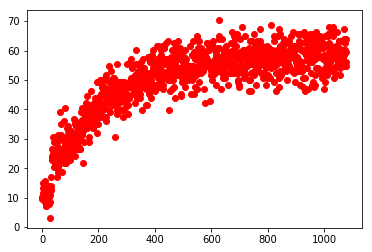

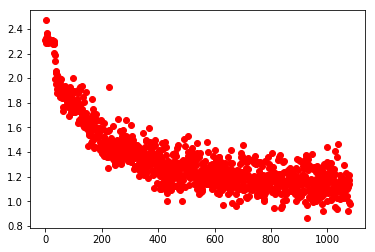

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

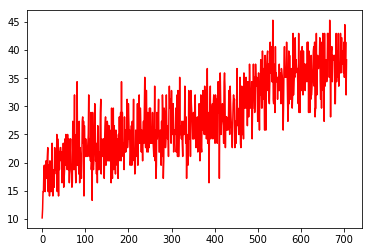

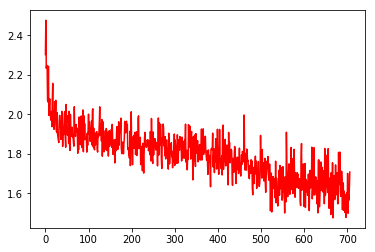

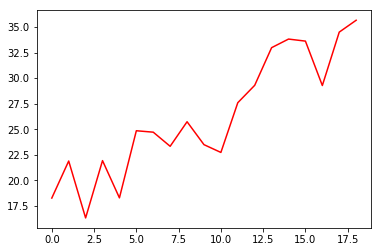

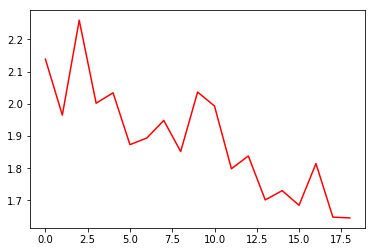

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()